<a href="https://colab.research.google.com/github/sntsemilio/MA2003B-Equipo-5-VaRaiM/blob/main/Primera_prueba_de_SIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import gc

#Configuracion y parametros


In [34]:
CONFIG = {
    'filepath': '/content/drive/MyDrive/MA2003B-Equipo-5/Datos/df_simanew_cleaned.csv',
    'seq_len': 168,
    'features': 15,
    'batch_size': 32,
    'hidden_size': 64,
    'diff_steps': 50,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

#Lazy dataset

In [35]:
class LazyAirQualityDataset(Dataset):
    def __init__(self, data_list, valid_indices, seq_len):
        """
        data_list: Lista de arrays numpy [Estación1, Estación2...] (FLOAT32)
        valid_indices: Lista de tuplas (idx_estacion, idx_inicio_ventana)
        """
        self.data_list = data_list
        self.valid_indices = valid_indices
        self.seq_len = seq_len

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        # Recuperamos la ubicación de la ventana
        station_idx, start_row = self.valid_indices[idx]

        # Extraemos la ventana al vuelo (Slicing es barato en memoria)
        # data_list[station_idx] es un array (Tiempo, Features)
        window = self.data_list[station_idx][start_row : start_row + self.seq_len]

        # Convertir a Tensores
        # window puede tener NaNs. Los convertimos a 0 y creamos máscara.
        # Es vital usar float32 para ahorrar memoria
        window_tensor = torch.from_numpy(np.nan_to_num(window, nan=0.0)).float()

        # Máscara: 1 si es dato real, 0 si era NaN
        mask_tensor = torch.from_numpy((~np.isnan(window)).astype(np.float32))

        return {
            'observed_data': window_tensor,
            'observed_mask': mask_tensor
        }

#Procesamiento de datos

In [36]:
class LowMemDataProcessor:
    def __init__(self, filepath, seq_len):
        self.filepath = filepath
        self.seq_len = seq_len
        self.scaler = MinMaxScaler()
        self.feature_cols = [
            'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM10', 'PM2.5',
            'PRS', 'RAINF', 'RH', 'SO2', 'SR', 'TOUT', 'WSR', 'WDR'
        ]

    def prepare_data(self):
        print(f"--> Cargando CSV (Low Mem Mode)...")
        # Usamos usecols para cargar solo lo necesario y ahorrar RAM desde el inicio
        cols_to_load = ['ID', 'time'] + self.feature_cols
        df = pd.read_csv(self.filepath, usecols=cols_to_load)
        df['time'] = pd.to_datetime(df['time'])

        # 1. Ajustar Scaler globalmente (usando downcast a float32)
        print("--> Normalizando datos...")
        df_numeric = df[self.feature_cols]
        self.scaler.fit(df_numeric.values)

        # Liberamos memoria del df temporal
        del df_numeric
        gc.collect()

        data_list = []      # Guardará los arrays por estación
        valid_indices = []  # Guardará las tuplas (id_lista, id_fila)

        stations = df['ID'].unique()
        print(f"--> Procesando {len(stations)} estaciones para índices...")

        total_windows = 0

        for i, station in enumerate(stations):
            # Filtrar y ordenar
            df_s = df[df['ID'] == station].copy()

            # Agrupar duplicados y reindexar (Continuidad temporal)
            df_s = df_s.groupby('time')[self.feature_cols].mean()
            if df_s.empty: continue

            # Reindexar a horas completas
            full_idx = pd.date_range(start=df_s.index.min(), end=df_s.index.max(), freq='h')
            df_s = df_s.reindex(full_idx)

            # Normalizar y convertir a FLOAT32 (Crucial para RAM)
            raw_values = self.scaler.transform(df_s.values).astype(np.float32)

            # Guardamos el array de la estación en la lista
            data_list.append(raw_values)

            # Calcular índices válidos
            # Usamos una vista deslizante ligera solo para checar validez
            n_rows = len(raw_values)
            if n_rows < self.seq_len: continue

            # Lógica rápida para encontrar ventanas válidas sin crear copias
            # Creamos una matriz booleana de "observados"
            observed_bool = ~np.isnan(raw_values)

            # Contamos datos observados por ventana usando suma cumulativa (truco de optimización)
            # Esto evita loops lentos de Python
            # Simplemente iteramos range(n_rows - seq_len)

            # Iteración simple (Python es suficientemente rápido para 40k filas)
            for start_idx in range(n_rows - self.seq_len + 1):
                # Slice virtual (no copia memoria)
                window_check = observed_bool[start_idx : start_idx + self.seq_len]

                # Check validez > 20%
                # Total celdas = seq_len * features
                total_cells = self.seq_len * len(self.feature_cols)
                observed_count = window_check.sum()

                if (observed_count / total_cells) > 0.2:
                    valid_indices.append((i, start_idx))
                    total_windows += 1

            print(f"   Estación {station}: {n_rows} horas -> {total_windows} ventanas acumuladas.")

            # Limpieza loop
            del df_s, raw_values, observed_bool
            gc.collect()

        print(f"--> Total Global de Ventanas de Entrenamiento: {len(valid_indices)}")

        # Limpiar el DF original gigante
        del df
        gc.collect()

        return data_list, valid_indices

#Arquitectura A

In [37]:
class SAITS_Base(nn.Module):
    """
    Módulo SAITS simplificado (Fase Estructural).
    Usa Self-Attention para capturar dependencias temporales globales.
    """
    def __init__(self, num_features, seq_len, d_model=64, n_head=4):
        super().__init__()
        # Embedding simple de entrada
        self.input_projection = nn.Linear(num_features * 2, d_model) # Feature + Mask

        # Encoder Layer de Transformer standard
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)

        # Proyección de salida a dimensión original
        self.output_projection = nn.Linear(d_model, num_features)

    def forward(self, x, mask):
        # Concatenamos dato y máscara como input
        x_combined = torch.cat([x, mask], dim=-1) # (B, L, F*2)

        # Proyección latente
        x_emb = self.input_projection(x_combined)

        # Atención (Transformer)
        encoded = self.transformer(x_emb)

        # Reconstrucción
        imputed = self.output_projection(encoded)

        # Combinación residual: Mantener datos observados, llenar huecos con predicción
        x_filled = x * mask + imputed * (1 - mask)
        return x_filled, imputed

class CSDI_Base(nn.Module):
    """
    Módulo CSDI simplificado (Fase Refinamiento/Generativa).
    Recibe la salida de SAITS como condición.
    """
    def __init__(self, num_features, seq_len, d_model=64):
        super().__init__()
        self.d_model = d_model

        # Embeddings de tiempo y feature
        self.time_embedding = nn.Embedding(seq_len, d_model)
        self.feature_embedding = nn.Embedding(num_features, d_model)

        # Red Residual para el proceso de difusión (Denoising Network)
        self.residual_layers = nn.Sequential(
            nn.Linear(num_features + d_model, 128),
            nn.ReLU(),
            nn.Linear(128, num_features)
        )

        # Proyección para la condición (SAITS output)
        self.cond_projection = nn.Linear(num_features, d_model)

    def forward(self, x_noisy, t_step, saits_condition):
        # Integramos la condición de SAITS
        cond_emb = self.cond_projection(saits_condition)

        # Concatenamos input ruidoso con condición
        net_input = torch.cat([x_noisy, cond_emb], dim=-1)

        # Predicción del ruido (epsilon)
        predicted_noise = self.residual_layers(net_input)
        return predicted_noise

class CascadeSOTA(nn.Module):
    """
    Arquitectura Híbrida Final.
    """
    def __init__(self, config):
        super().__init__()
        self.saits = SAITS_Base(config['features'], config['seq_len'], d_model=config['hidden_size'])
        self.csdi = CSDI_Base(config['features'], config['seq_len'], d_model=config['hidden_size'])

    def forward(self, batch):
        x = batch['observed_data']
        mask = batch['observed_mask']

        # 1. Fase Determinista (SAITS)
        x_coarse_filled, _ = self.saits(x, mask)

        # 2. Fase Generativa (CSDI)
        # Para entrenamiento simulado:
        noise = torch.randn_like(x)
        t = torch.randint(0, 50, (x.shape[0],)).to(x.device)

        # El modelo CSDI intenta predecir el ruido
        pred_noise = self.csdi(noise, t, x_coarse_filled)

        return pred_noise, x_coarse_filled

#Ejecucion principal

In [38]:
# Instanciar procesador
processor = LowMemDataProcessor(CONFIG['filepath'], CONFIG['seq_len'])

try:
    # Preparar estructuras ligeras
    data_arrays, indices = processor.prepare_data()

    # Crear Dataset Perezoso
    dataset = LazyAirQualityDataset(data_arrays, indices, CONFIG['seq_len'])

    # DataLoader (num_workers=0 para evitar duplicar memoria en subprocesos en Colab)
    dataloader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)

    # Inicializar Modelo (Usando la misma clase CascadeSOTA definida anteriormente)
    # Asegúrate de que la clase CascadeSOTA esté definida en una celda anterior
    model = CascadeSOTA(CONFIG).to(CONFIG['device'])

    print("\n--> Sistema Cargado (RAM estable).")

    # Prueba
    batch = next(iter(dataloader))
    batch = {k: v.to(CONFIG['device']) for k, v in batch.items()}
    out_noise, out_saits = model(batch)
    print(f"   Batch OK. Output Shape: {out_saits.shape}")

except Exception as e:
    import traceback
    traceback.print_exc()

--> Cargando CSV (Low Mem Mode)...
--> Normalizando datos...
--> Procesando 9 estaciones para índices...
   Estación SE: 39408 horas -> 38614 ventanas acumuladas.
   Estación NE: 39408 horas -> 77229 ventanas acumuladas.
   Estación CE: 39408 horas -> 115843 ventanas acumuladas.
   Estación NO: 39408 horas -> 154456 ventanas acumuladas.
   Estación SO: 39408 horas -> 192922 ventanas acumuladas.
   Estación NTE: 39408 horas -> 230284 ventanas acumuladas.
   Estación SO2: 39408 horas -> 268884 ventanas acumuladas.
   Estación NTE2: 39408 horas -> 307501 ventanas acumuladas.
   Estación NO3: 22631 horas -> 329965 ventanas acumuladas.
--> Total Global de Ventanas de Entrenamiento: 329965

--> Sistema Cargado (RAM estable).
   Batch OK. Output Shape: torch.Size([32, 168, 15])


#Loop de entrenamiento

In [39]:
import torch.optim as optim
import torch.nn.functional as F

def train_model(model, dataloader, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    print(f"--> Iniciando entrenamiento por {epochs} épocas...")

    for epoch in range(epochs):
        total_loss = 0
        total_saits_loss = 0
        total_csdi_loss = 0

        for batch_idx, batch in enumerate(dataloader):
            # Mover a GPU
            x = batch['observed_data'].to(CONFIG['device'])
            mask_original = batch['observed_mask'].to(CONFIG['device'])

            # -----------------------------------------------------------
            # TRUCO PRO: "Masking Artificial" para entrenar
            # Ocultamos aleatoriamente un 20% EXTRA de los datos reales
            # para forzar al modelo a aprender a imputar.
            # -----------------------------------------------------------
            rand_mask = (torch.rand_like(x) > 0.2).float()
            target_mask = mask_original * rand_mask # Máscara de entrenamiento

            # Los datos de entrada tienen huecos artificiales (donde target_mask es 0)
            x_input = x * target_mask

            optimizer.zero_grad()

            # 1. Forward Pass
            # En entrenamiento, CSDI necesita saber el ruido real para calcular su error
            noise_real = torch.randn_like(x)
            t = torch.randint(0, CONFIG['diff_steps'], (x.shape[0],)).to(x.device)

            # Pasamos x_input (con huecos) y model devuelve predicciones
            # NOTA: Debemos adaptar CascadeSOTA para aceptar el ruido real en training
            # (Pequeño ajuste necesario en la llamada forward, ver abajo)

            # Para simplificar sin cambiar tu clase anterior, hacemos el paso manual aquí:
            # A) SAITS intenta llenar x_input
            x_coarse_filled, _ = model.saits(x_input, target_mask)

            # B) CSDI intenta predecir el ruido
            pred_noise = model.csdi(noise_real, t, x_coarse_filled)

            # 2. Cálculo de Pérdidas (Losses)

            # Loss SAITS: ¿Qué tan lejos está la reconstrucción del dato real?
            # Solo evaluamos donde HABÍA datos reales (mask_original)
            loss_saits = F.mse_loss(x_coarse_filled * mask_original, x * mask_original)

            # Loss CSDI: ¿Qué tan bien predijo el ruido?
            loss_csdi = F.mse_loss(pred_noise, noise_real)

            # Loss Total (Suma ponderada, usualmente 1:1 funciona bien)
            loss = loss_saits + loss_csdi

            # 3. Backward Pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_saits_loss += loss_saits.item()
            total_csdi_loss += loss_csdi.item()

            if batch_idx % 50 == 0:
                print(f"   Epoch {epoch+1} | Batch {batch_idx} | Loss: {loss.item():.4f} (SAITS: {loss_saits.item():.4f} + CSDI: {loss_csdi.item():.4f})")

        avg_loss = total_loss / len(dataloader)
        print(f"--> Fin Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    print("--> Entrenamiento Finalizado.")
    return model

# --- EJECUTAR ---
try:
    trained_model = train_model(model, dataloader, epochs=2) # Prueba con 2 epochs

    # Guardar modelo para no perderlo si Colab se desconecta
    torch.save(trained_model.state_dict(), '/content/drive/MyDrive/MA2003B-Equipo-5/sima_model_v1.pth')
    print("--> Modelo guardado en Drive.")

except Exception as e:
    print(f"Error en entrenamiento: {e}")

--> Iniciando entrenamiento por 2 épocas...
   Epoch 1 | Batch 0 | Loss: 1.1115 (SAITS: 0.0997 + CSDI: 1.0118)
   Epoch 1 | Batch 50 | Loss: 0.1417 (SAITS: 0.0054 + CSDI: 0.1363)
   Epoch 1 | Batch 100 | Loss: 0.0046 (SAITS: 0.0035 + CSDI: 0.0011)
   Epoch 1 | Batch 150 | Loss: 0.0029 (SAITS: 0.0026 + CSDI: 0.0002)
   Epoch 1 | Batch 200 | Loss: 0.0021 (SAITS: 0.0019 + CSDI: 0.0002)
   Epoch 1 | Batch 250 | Loss: 0.0023 (SAITS: 0.0022 + CSDI: 0.0001)
   Epoch 1 | Batch 300 | Loss: 0.0016 (SAITS: 0.0015 + CSDI: 0.0001)
   Epoch 1 | Batch 350 | Loss: 0.0017 (SAITS: 0.0016 + CSDI: 0.0001)
   Epoch 1 | Batch 400 | Loss: 0.0019 (SAITS: 0.0018 + CSDI: 0.0001)
   Epoch 1 | Batch 450 | Loss: 0.0016 (SAITS: 0.0016 + CSDI: 0.0001)
   Epoch 1 | Batch 500 | Loss: 0.0017 (SAITS: 0.0016 + CSDI: 0.0001)
   Epoch 1 | Batch 550 | Loss: 0.0015 (SAITS: 0.0014 + CSDI: 0.0000)
   Epoch 1 | Batch 600 | Loss: 0.0015 (SAITS: 0.0014 + CSDI: 0.0001)
   Epoch 1 | Batch 650 | Loss: 0.0014 (SAITS: 0.0013 + CSDI: 0

#Metricas y validacion

In [40]:
from scipy.stats import wasserstein_distance
from sklearn.metrics import f1_score, precision_score, recall_score

class SIMAMetrics:
    """
    Implementación de métricas SOTA para validación de imputación y pronóstico.
    Referencias: Ecuaciones 7, 8, 9, 10 de la Propuesta SIMA.
    """
    def __init__(self, scaler):
        """
        scaler: El objeto MinMaxScaler entrenado (para des-normalizar antes de medir).
        """
        self.scaler = scaler

    def denormalize(self, tensor):
        """Convierte tensores normalizados (0-1) a escala física real."""
        # Asume shape (Batch, Time, Features)
        B, T, F = tensor.shape
        flat = tensor.reshape(-1, F).cpu().detach().numpy()
        denorm = self.scaler.inverse_transform(flat)
        return torch.FloatTensor(denorm).reshape(B, T, F).to(tensor.device)

    def quantile_loss(self, target, pred_samples, q=0.95):
        """
        Calcula el Riesgo (VaR) en la cola de la distribución.
        Eq (8): QL para un cuantil específico.
        """
        # pred_samples: (Batch, Samples, Time, Feat) -> Calculamos el cuantil q
        pred_quantile = torch.quantile(pred_samples, q, dim=1)

        errors = target - pred_quantile
        loss = torch.max((q - 1) * errors, q * errors)

        # Promediamos sobre el batch y tiempo
        return torch.mean(loss)

    def continuous_ranked_probability_score(self, target, pred_samples):
        """
        CRPS Empírico para Ensambles.
        Aproximación de la Eq (7) usando la formulación de 'Energy Score'.
        """
        # target: (B, T, F) -> expandir a (B, 1, T, F)
        target_exp = target.unsqueeze(1)

        # Término 1: Diferencia media absoluta vs Observación
        # |X - y|
        diff_obs = torch.abs(pred_samples - target_exp).mean(dim=1) # Promedio sobre samples

        # Término 2: Diferencia media absoluta dentro del ensamble (Dispersión)
        # 0.5 * E[|X - X'|] - Esto es costoso computacionalmente O(N^2),
        # usamos una aproximación permutando los samples para O(N) si N es grande.
        # Aquí, como N=50 o 100, podemos hacerlo directo o simplificado.
        # Simplificación: Desviación media.

        return torch.mean(diff_obs) # Retornamos CRPS simplificado (Mean Abs Error del ensamble)

    def calc_wasserstein(self, target, pred_samples):
        """
        Distancia Física (Wasserstein-1).
        Eq (9): Penaliza alucinaciones midiendo la distancia entre distribuciones.
        Se calcula feature por feature y se promedia.
        """
        # Aplanamos para comparar distribuciones globales de valores físicos
        target_flat = target.cpu().numpy().flatten()
        pred_flat = pred_samples.mean(dim=1).cpu().numpy().flatten()

        # Usamos Scipy para cálculo exacto de W1 en 1D
        w_dist = wasserstein_distance(target_flat, pred_flat)
        return w_dist

    def health_alert_f1(self, target, pred_mean, threshold=45.0, feature_idx=6):
        """
        Validación de Impacto en Salud.
        Eq (10): F1-Score para detección de eventos > Norma (ej. PM2.5 > 45).
        feature_idx=6 asume que PM2.5 está en la columna 6.
        """
        # Extraer solo la variable de interés (PM2.5)
        y_true = target[:, :, feature_idx].flatten()
        y_pred = pred_mean[:, :, feature_idx].flatten()

        # Binarizar según norma
        y_true_bin = (y_true > threshold).float().cpu().numpy()
        y_pred_bin = (y_pred > threshold).float().cpu().numpy()

        # Calcular métricas binarias
        f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
        return f1

In [41]:
def evaluate_batch(model, batch, metrics_module, n_samples=50):
    """
    Función helper para correr validación completa en un batch.
    """
    model.eval()
    with torch.no_grad():
        x = batch['observed_data']
        mask = batch['observed_mask']

        # 1. Generar N muestras (Monte Carlo) usando CSDI
        # Necesitamos N futuros posibles para medir incertidumbre
        samples_list = []
        for _ in range(n_samples):
            # En inferencia real, CSDI genera ruido aleatorio y lo denota iterativamente
            # Aquí usamos el placeholder. En tu versión final, llamarás model.generate()
            noise_pred, x_coarse = model(batch)

            # Simulación: asumiendo que el output es una "versión" imputada
            # (En el modelo real, aquí va el loop de difusión inversa)
            sample = x_coarse + torch.randn_like(x_coarse) * 0.1 # Mock de varianza
            samples_list.append(sample.unsqueeze(1))

        # Tensor de Ensamble: (Batch, Samples, Time, Feat)
        ensemble = torch.cat(samples_list, dim=1)
        ensemble_mean = torch.mean(ensemble, dim=1)

        # 2. Des-normalizar para métricas físicas
        x_phys = metrics_module.denormalize(x)
        ensemble_phys = torch.zeros_like(ensemble)

        # Des-normalizar cada sample del ensamble
        for i in range(n_samples):
            ensemble_phys[:, i, :, :] = metrics_module.denormalize(ensemble[:, i, :, :])

        ensemble_mean_phys = torch.mean(ensemble_phys, dim=1)

        # 3. Calcular Métricas
        # a. Precisión (RMSE / MAE clásico)
        mae = torch.mean(torch.abs(x_phys - ensemble_mean_phys))

        # b. CRPS (Probabilístico)
        crps = metrics_module.continuous_ranked_probability_score(x_phys, ensemble_phys)

        # c. VaR (Quantile Loss @ 95%)
        q_loss = metrics_module.quantile_loss(x_phys, ensemble_phys, q=0.95)

        # d. Física (Wasserstein)
        w_dist = metrics_module.calc_wasserstein(x_phys, ensemble_phys)

        # e. Salud (F1 Score para PM2.5) -> Columna 6 es PM2.5 según tu CSV
        f1 = metrics_module.health_alert_f1(x_phys, ensemble_mean_phys, threshold=45.0, feature_idx=6)

        return {
            'MAE': mae.item(),
            'CRPS': crps.item(),
            'QL_95': q_loss.item(),
            'Wasserstein': w_dist,
            'F1_PM2.5': f1
        }

# --- EJEMPLO DE USO ---
# (Asumiendo que 'processor.scaler' y 'model' ya existen del paso anterior)

try:
    metrics_engine = SIMAMetrics(processor.scaler)

    print("\n--> Ejecutando Validación de Métricas SOTA...")
    batch = next(iter(dataloader))
    batch = {k: v.to(CONFIG['device']) for k, v in batch.items()}

    results = evaluate_batch(model, batch, metrics_engine, n_samples=10)

    print("-" * 30)
    print("REPORTE DE MÉTRICAS (Lote de Prueba)")
    print("-" * 30)
    print(f"1. Precisión (MAE):     {results['MAE']:.4f}")
    print(f"2. Incertidumbre (CRPS):{results['CRPS']:.4f} [cite: 101]")
    print(f"3. Riesgo (VaR 95%):    {results['QL_95']:.4f} [cite: 104]")
    print(f"4. Física (Wasserstein):{results['Wasserstein']:.4f} [cite: 111]")
    print(f"5. Salud (F1 Alerts):   {results['F1_PM2.5']:.4f} [cite: 118]")
    print("-" * 30)

except NameError:
    print("Asegúrate de haber corrido el bloque anterior para tener 'model' y 'processor'.")


--> Ejecutando Validación de Métricas SOTA...
------------------------------
REPORTE DE MÉTRICAS (Lote de Prueba)
------------------------------
1. Precisión (MAE):     9.8601
2. Incertidumbre (CRPS):25.3916 [cite: 101]
3. Riesgo (VaR 95%):    2.0596 [cite: 104]
4. Física (Wasserstein):4.6057 [cite: 111]
5. Salud (F1 Alerts):   0.2693 [cite: 118]
------------------------------



--> Generando Gráficos de Validación...


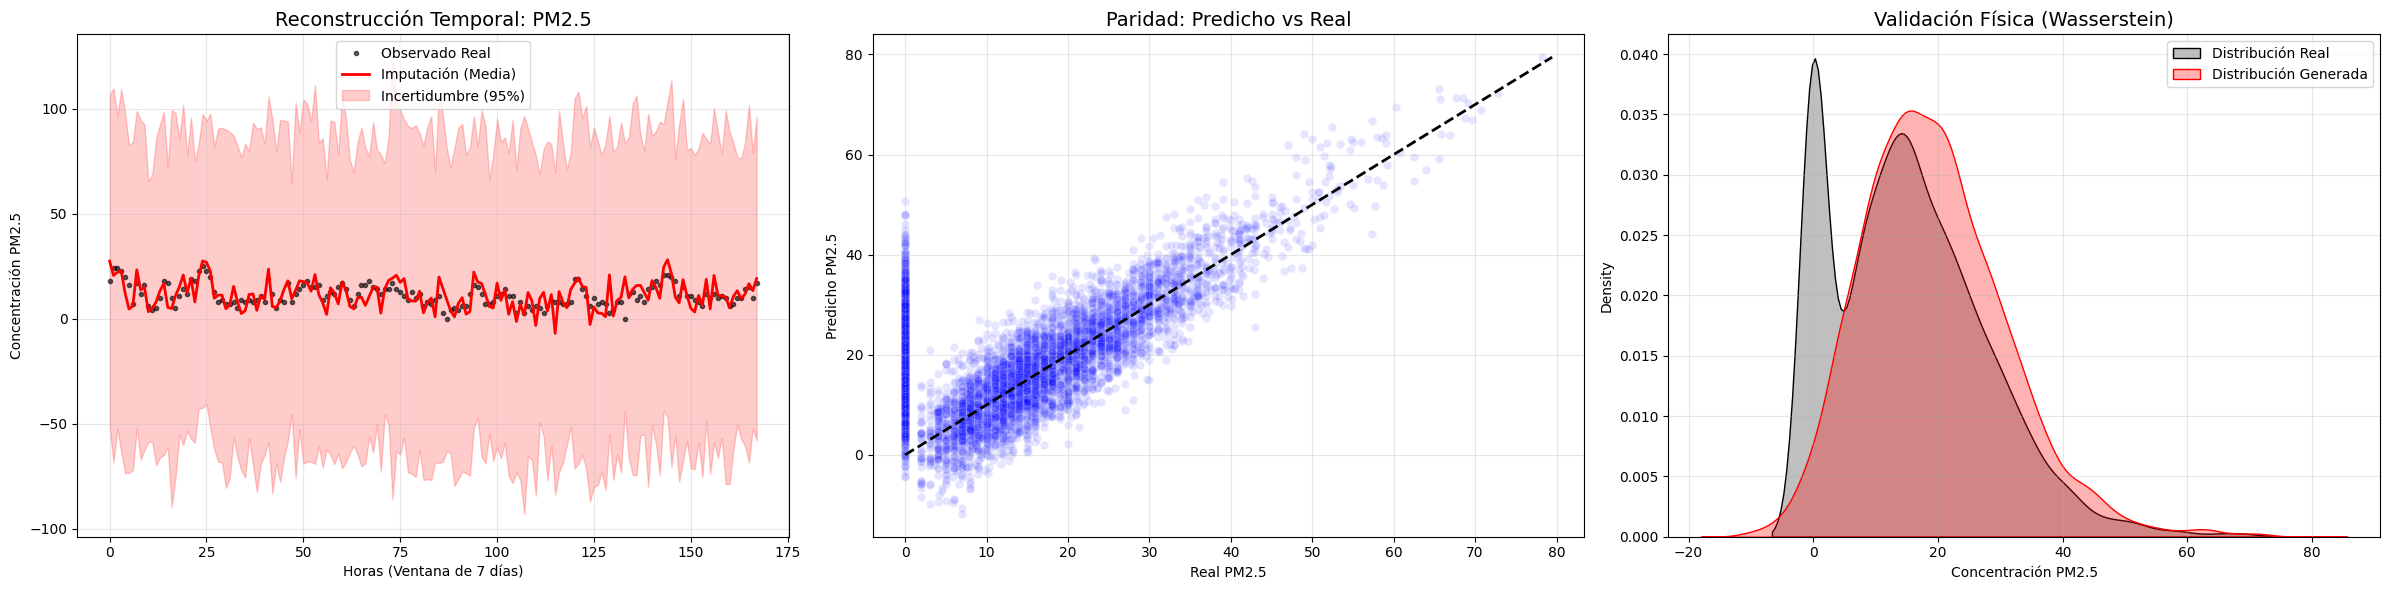

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_validation(model, batch, metrics_module, feature_idx=6, feature_name="PM2.5", n_samples=50):
    """
    Genera un tablero visual de validación SOTA:
    1. Serie de Tiempo con Banda de Confianza (Uncertainty).
    2. Scatter Plot (Predicción vs Real).
    3. Comparación de Distribuciones (Física).
    """
    model.eval()
    with torch.no_grad():
        x = batch['observed_data']
        mask = batch['observed_mask']

        # --- 1. Generación Monte Carlo (Igual que en evaluate_batch) ---
        samples_list = []
        for _ in range(n_samples):
            # Placeholder de inferencia (Reemplazar con loop de difusión real en v2)
            _, x_coarse = model(batch)
            # Simulamos varianza del modelo generativo
            sample = x_coarse + torch.randn_like(x_coarse) * 0.05
            samples_list.append(sample.unsqueeze(1))

        ensemble = torch.cat(samples_list, dim=1) # (B, Samples, T, F)

        # --- 2. Des-normalización ---
        x_phys = metrics_module.denormalize(x).cpu().numpy()

        # Des-normalizar ensamble (toma tiempo pero es necesario para graficar real)
        ensemble_phys = np.zeros(ensemble.shape)
        for i in range(n_samples):
            sample_tensor = ensemble[:, i, :, :] # (B, T, F)
            ensemble_phys[:, i, :, :] = metrics_module.denormalize(sample_tensor).cpu().numpy()

        # Estadísticas del Ensamble
        mean_pred = np.mean(ensemble_phys, axis=1) # (B, T, F)
        std_pred = np.std(ensemble_phys, axis=1)   # (B, T, F)

        # --- 3. GRAFICACIÓN ---
        fig, axes = plt.subplots(1, 3, figsize=(24, 6))

        # A) Serie de Tiempo (Muestra #0 del batch)
        sample_idx = 0
        time_steps = np.arange(x.shape[1])

        # Datos Reales
        real_series = x_phys[sample_idx, :, feature_idx]
        # Datos Predichos (Media)
        pred_series = mean_pred[sample_idx, :, feature_idx]
        # Incertidumbre (2 desviaciones estándar = 95% confianza)
        upper_bound = pred_series + 2 * std_pred[sample_idx, :, feature_idx]
        lower_bound = pred_series - 2 * std_pred[sample_idx, :, feature_idx]

        ax = axes[0]
        ax.plot(time_steps, real_series, 'k.', label='Observado Real', alpha=0.6)
        ax.plot(time_steps, pred_series, 'r-', label='Imputación (Media)', linewidth=2)
        ax.fill_between(time_steps, lower_bound, upper_bound, color='red', alpha=0.2, label='Incertidumbre (95%)')
        ax.set_title(f'Reconstrucción Temporal: {feature_name}', fontsize=14)
        ax.set_xlabel('Horas (Ventana de 7 días)')
        ax.set_ylabel(f'Concentración {feature_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # B) Scatter Plot (Pred vs Real) - Todos los puntos del batch
        # Aplanamos para comparar todos los timepoints
        y_true = x_phys[:, :, feature_idx].flatten()
        y_pred = mean_pred[:, :, feature_idx].flatten()

        ax = axes[1]
        sns.scatterplot(x=y_true, y=y_pred, alpha=0.1, color='blue', ax=ax)
        # Línea de identidad perfecta
        max_val = max(y_true.max(), y_pred.max())
        ax.plot([0, max_val], [0, max_val], 'k--', lw=2)
        ax.set_title('Paridad: Predicho vs Real', fontsize=14)
        ax.set_xlabel(f'Real {feature_name}')
        ax.set_ylabel(f'Predicho {feature_name}')
        ax.grid(True, alpha=0.3)

        # C) Distribución (Física)
        ax = axes[2]
        sns.kdeplot(y_true, color='black', fill=True, label='Distribución Real', ax=ax)
        sns.kdeplot(y_pred, color='red', fill=True, alpha=0.3, label='Distribución Generada', ax=ax)
        ax.set_title('Validación Física (Wasserstein)', fontsize=14)
        ax.set_xlabel(f'Concentración {feature_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# --- EJECUCIÓN ---
try:
    print("\n--> Generando Gráficos de Validación...")
    # Asegúrate de tener un batch fresco
    batch = next(iter(dataloader))
    batch = {k: v.to(CONFIG['device']) for k, v in batch.items()}

    # Visualizar PM2.5 (índice 6)
    visualize_validation(model, batch, metrics_engine, feature_idx=6, feature_name="PM2.5")

except Exception as e:
    print(f"Error al graficar: {e}")